<a href="https://colab.research.google.com/github/brentkendrick/HPLC-Data-Analysis/blob/master/HPLC%20data%20normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# %pip install peakutils

In [1]:
# import modules
import pandas as pd
import numpy as np

import os
import math
import warnings

from hplc.ui.plotly_go import raw_data_graph, baseline_check_graph, peak_ctr_check_graph
from hplc.ui.static_plots import inset_plot
from hplc.ui.static_plots import inset_plot_zoom2_stacked
from hplc.ui.create_df import create_df

from scipy import integrate

import matplotlib.pyplot as plt


import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline


# Code start

In [2]:
df1 = create_df()

Enter 1 to import Agilent Chemstation file(s), 
                or 2 to import example data2


In [3]:
df1colnames = df1.columns

# Create interactive graph to interrogate region of interest

In [4]:
raw_data_graph(df1)

In [27]:
# Truncate dataframe to region of interest

df_trnc = df1.copy()
left_cut = 13.5
right_cut = 40.0
filt = ((df_trnc.iloc[:,0]> left_cut) & 
        (df_trnc.iloc[:,0]< right_cut))#assign to variable

df_trnc = df_trnc.loc[filt] 

# x_val = df_trnc.iloc[:,0]
# y_val = df_trnc.iloc[:,1]

# Raw chromatograms

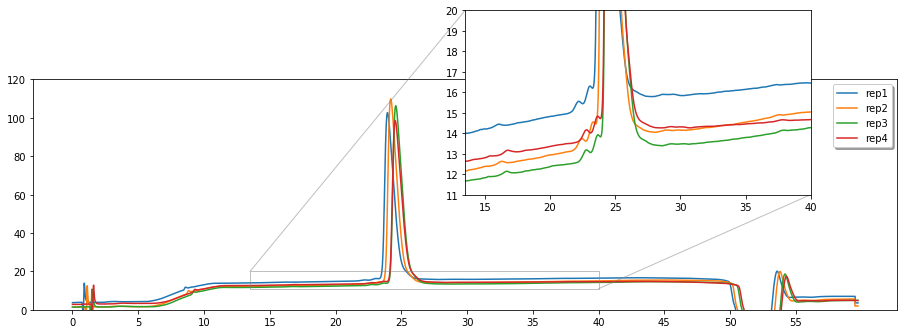

In [28]:
inset_plot(df1,ylim = 120, x1=left_cut,x2=right_cut,y1=11,y2=20)

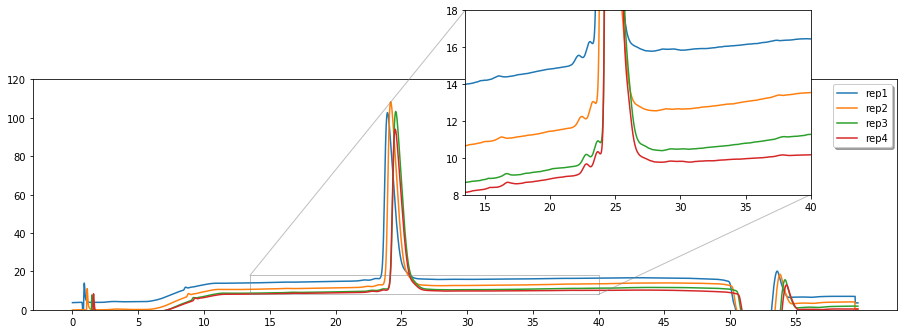

In [29]:
inset_plot_zoom2_stacked(df1, offint=-1.5, ylim=120, x1=left_cut, x2=right_cut, y1=8, y2=18)

# Baseline correction algorithm 1
based on Eilers Asymmetric Least Squares Smoothing

There are two parameters: p for asymmetry and λ for smoothness. Both have to be tuned to the data at hand. 
For chemstation chromatograms, generally 1.0e-9 ≤ p ≤ 100.0e-9 is a good choice (for a signal with positive peaks) and 1.0e4 ≤ λ ≤ 100.0e4, but exceptions may occur. In any case one should vary λ on a grid that is approximately linear for log λ. Often visual inspection is sufficient to get good parameter values.

reference: https://stackoverflow.com/questions/29156532/python-baseline-correction-library/29185844


In [30]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z


In [31]:

lam = 40.0e4 # larger than 5e6 causes concave down curvature, smaller causes upward
p = 30.0e-9 # larger than 10e-9 flattens bl around large peaks, smaller no impact

x_val = df_trnc.iloc[:,0]
y_val = df_trnc.iloc[:,2]


base2=baseline_als_optimized(y_val, lam, p, niter=100)

In [32]:
baseline_check_graph(x_val, y_val, base2, left_cut, right_cut, min_y=0, max_y=100)

In [33]:
# Iterate through all data

lam = 40.0e4 # larger than 5e6 causes concave down curvature, smaller causes upward
p = 30.0e-9 # larger than 10e-9 flattens bl around large peaks, smaller no impact

corr_df1 = pd.DataFrame(columns=df1.columns)

for i in range(len(df1.columns)-1):

    x_val = df_trnc.iloc[:,0]
    y_val = df_trnc.iloc[:,(i+1)]

    base = baseline_als_optimized(y_val, lam, p, niter=100)
    
    corr_df1.iloc[:,0] = x_val
    
    corr_df1.iloc[:,(i+1)] = y_val-base

corr_df1.reset_index(drop=True, inplace=True)

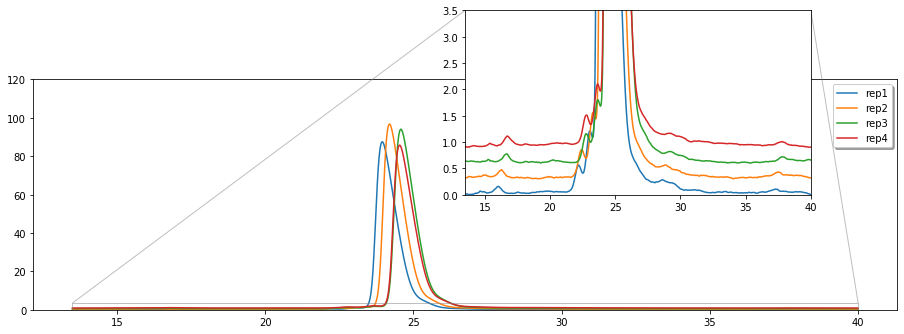

In [34]:
inset_plot_zoom2_stacked(corr_df1, offint=0.3, ylim=120, x1=left_cut, x2=right_cut, y1=0, y2=3.5)

# Peak centering

In [35]:
x_val = np.asarray(corr_df1.iloc[:,0])
y_val = np.asarray(corr_df1.iloc[:,1])

# find peak center X, and Y values
indexes = peakutils.indexes(y_val, thres=.35, min_dist=1)
print(indexes)
print(x_val[indexes], y_val[indexes])

# Alternate method: Fit peak to Gaussian and find center
peaks_x = peakutils.interpolate(x_val, y_val, ind=indexes)
print(peaks_x)

[1076]
[23.94680645] [87.49217842]
[23.95835165]


In [36]:
peak_ctr_check_graph(x_val, y_val, indexes, peaks_x, left_cut, right_cut, min_y=0, max_y=100)

In [37]:
# Find maximum peak center X, and Y values for every data column

x_val = np.asarray(corr_df1.iloc[:,0])
xctrs = []
yctrs = []

for i in range(len(corr_df1.columns)-1):
    y_val = np.asarray(corr_df1.iloc[:,(i+1)])

    indexes = peakutils.indexes(y_val, thres=.35, min_dist=1)
    xctrs.append(x_val[indexes][0].tolist())
    yctrs.append(y_val[indexes][0].tolist())

print(xctrs, yctrs)

[23.9468064453504, 24.1894777713066, 24.5777518928364, 24.5389244806834] [87.49217841674763, 96.43542223614088, 93.46014609902625, 84.8487235000152]


In [38]:
corr_df1.head()

x-data      rep1      rep2      rep3      rep4
0  13.502233  0.005637  0.021108  0.036863  0.008906
1  13.511939  0.004909  0.020937  0.036931  0.009193
2  13.521646  0.004731  0.020631  0.037191  0.009597
3  13.531353  0.005409  0.020461  0.037458  0.010001
4  13.541060  0.006636  0.020425  0.037354  0.010228

In [39]:
RTdelta = (corr_df1.iloc[1, 0] - corr_df1.iloc[0, 0]) # retention time data interval
RTdelta

0.009706853038299101

In [40]:
# Shift the x-axis of the data to align to max peak

for i in range(len(corr_df1.columns)-2):
    shft = (int(round((xctrs[i+1]-xctrs[0])/RTdelta)))  #calculate the integer rows to shift data relative to 1st sample
    corr_df1.iloc[:,(i+2)]=corr_df1.iloc[:,(i+2)].shift(-shft)
# corr_df1.tail()

In [41]:
# Fill in ends of data after dataframe shift
corr_df1.ffill(axis = 0, inplace=True) 
corr_df1.bfill(axis = 0, inplace=True) 

corr_df1

x-data      rep1      rep2      rep3      rep4
0     13.502233  0.005637  0.042160  0.034186  0.027724
1     13.511939  0.004909  0.043405  0.033281  0.028413
2     13.521646  0.004731  0.043911  0.032220  0.029221
3     13.531353  0.005409  0.043947  0.031293  0.029792
4     13.541060  0.006636  0.043512  0.030290  0.030127
...         ...       ...       ...       ...       ...
2725  39.953407  0.004523  0.016191  0.056276  0.001806
2726  39.963114  0.003352  0.016191  0.056276  0.001806
2727  39.972821  0.002242  0.016191  0.056276  0.001806
2728  39.982528  0.001193  0.016191  0.056276  0.001806
2729  39.992235 -0.000101  0.016191  0.056276  0.001806

[2730 rows x 5 columns]

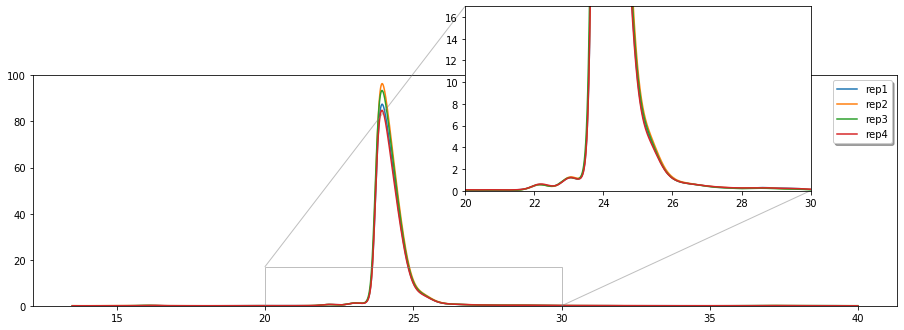

In [42]:
inset_plot(corr_df1,ylim = 100, x1=20,x2=30,y1=0,y2=17)

# Area normalize the data

In [43]:
def area_norm(df):
    """Normalize to area of 100"""

    proteins = list(df.columns)[1:]

    for i in proteins:
        dy = integrate.trapz(df[i], df[df.columns[0]]) 
        df[i] = df[i]/abs(dy)*100 #absolute value because decreasing x-values give negative area
    return df

In [44]:
area_norm_df = corr_df1.copy()
area_norm_df.reset_index(drop=True,inplace=True)
area_norm_df = area_norm(area_norm_df)
area_norm_df

x-data      rep1      rep2      rep3      rep4
0     13.502233  0.007261  0.049520  0.041130  0.036659
1     13.511939  0.006324  0.050982  0.040041  0.037570
2     13.521646  0.006094  0.051577  0.038765  0.038638
3     13.531353  0.006967  0.051619  0.037650  0.039393
4     13.541060  0.008547  0.051108  0.036442  0.039836
...         ...       ...       ...       ...       ...
2725  39.953407  0.005826  0.019017  0.067706  0.002388
2726  39.963114  0.004317  0.019017  0.067706  0.002388
2727  39.972821  0.002887  0.019017  0.067706  0.002388
2728  39.982528  0.001536  0.019017  0.067706  0.002388
2729  39.992235 -0.000130  0.019017  0.067706  0.002388

[2730 rows x 5 columns]

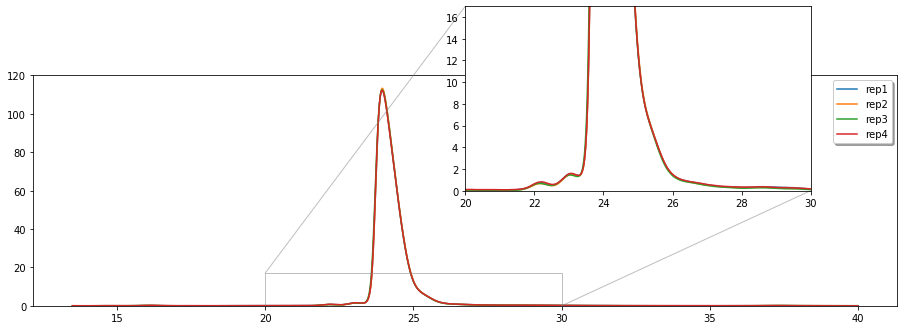

In [45]:
inset_plot(area_norm_df,ylim = 120, x1=20,x2=30,y1=0,y2=17)

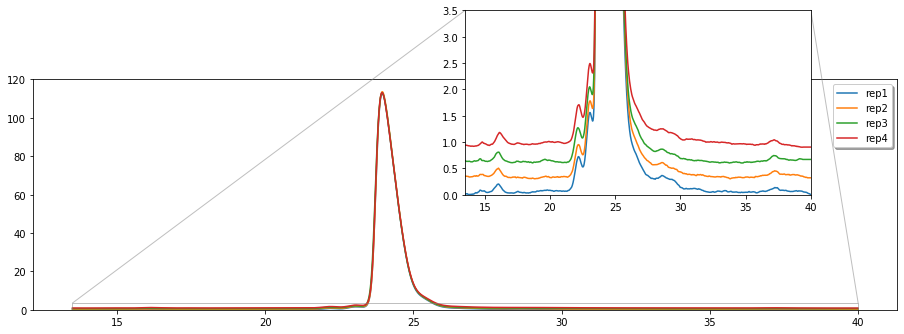

In [46]:
inset_plot_zoom2_stacked(area_norm_df, offint=0.3, ylim=120, x1=left_cut, x2=right_cut, y1=0, y2=3.5)